# NLP Deep Learning Project:
le:

The goal of this project is to build a deep learning model to classify tweets related to natural disasters. This involves identifying whether a tweet is about a real disaster or not, aiding in faster response and resource allocation during emerge
# Problem Description:

In this project, we aim to solve a text classification problem where the objective is to determine whether a given tweet is related to a natural disaster. This classification will help in efficiently filtering and responding to relevant tweets during emergencies.
ncies.


**Loading the dataset**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional



import random
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load training and test datasets
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')  
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')    

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Exploratory Data Analysis (EDA)
In this section, we perform a comprehensive analysis of the dataset to uncover patterns, identify anomalies, and gain insights that will inform our modeling approach.

In [4]:
# Training data information
print("Training Data Info:")
train_df.info()

print("\nTest Data Info:")
test_df.info()

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [5]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())

print("\nMissing values in test data:")
print(test_df.isnull().sum())


Missing values in training data:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing values in test data:
id             0
keyword       26
location    1105
text           0
dtype: int64


In [6]:
# Statistical summary
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


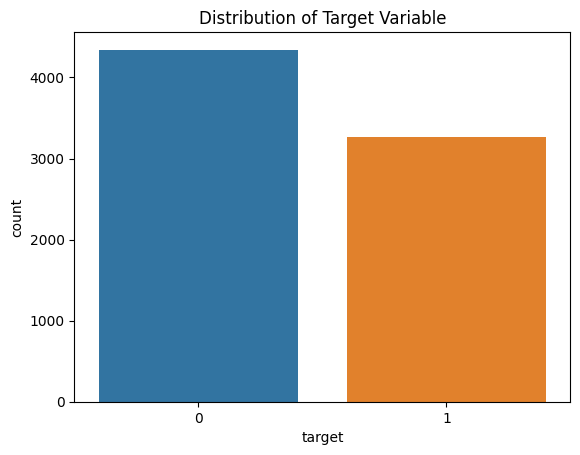

In [7]:
# Distribution of target variable
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


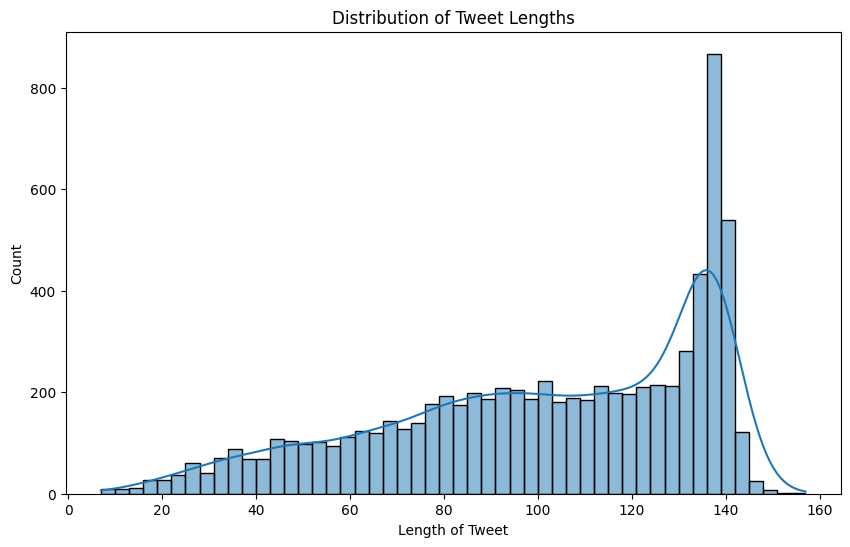

In [8]:
# Add a new column for text length
train_df['text_length'] = train_df['text'].apply(len)

# Plot distribution of text lengths
plt.figure(figsize=(10,6))
sns.histplot(train_df['text_length'], bins=50, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweet')
plt.show()

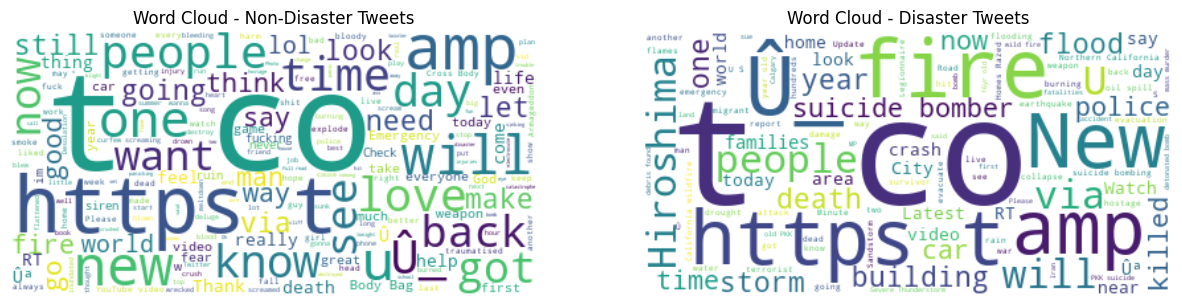

In [24]:
# wordcloud viz
from wordcloud import WordCloud, STOPWORDS

# Combine all texts for non-disaster and disaster tweets
non_disaster_text = ' '.join(train_df[train_df['target'] == 0]['text'].tolist())
disaster_text = ' '.join(train_df[train_df['target'] == 1]['text'].tolist())

# Generate word cloud for non-disaster tweets
wordcloud_non_disaster = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=200).generate(non_disaster_text)

# Generate word cloud for disaster tweets
wordcloud_disaster = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=200).generate(disaster_text)

# Display the word clouds
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Word Cloud - Non-Disaster Tweets')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Word Cloud - Disaster Tweets')
plt.axis('off')

plt.show()


# Data Preprocessing


Preparing the data is crucial for improving the performance of our deep learning model. This includes cleaning the text, handling missing values, and transforming the data into a format suitable for modeling.


In [17]:
train_df = train_df.dropna(subset=['text', 'target']).reset_index(drop=True)
test_df = test_df.dropna(subset=['text']).reset_index(drop=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = text.lower()
    text = text.replace('\n', ' ')
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    doc = nlp(text)

    cleaned_tokens = []
    for token in doc:
        if token.text not in STOP_WORDS and not token.is_punct and not token.is_space:
            cleaned_tokens.append(token.lemma_)

    cleaned_tokens = ' '.join(cleaned_tokens)
    
    return cleaned_tokens


train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)
train_df[['text', 'clean_text']].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,get send photo ruby alaska smoke wildfire pour...


In [18]:
# Parameters
VOCAB_SIZE = 10000
OOV_TOKEN = '<OOV>'
MAX_LENGTH = 50
TRUNC_TYPE='post'
PADDING_TYPE='post'


tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(train_df['clean_text'])

train_sequences = tokenizer.texts_to_sequences(train_df['clean_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['clean_text'])

train_padded = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)
test_padded = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

In [25]:
# Assuming 'target' is binary (0 and 1)
y = train_df['target'].values
X_train, X_val, y_train, y_val = train_test_split(train_padded, y, test_size=0.2, random_state=SEED)
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (6090, 50)
Validation set shape: (1523, 50)


# Model Building and Training

We will build a deep learning model using an Embedding layer followed by a Bidirectional LSTM layer. This architecture is effective for capturing contextual information in text data.

In [26]:
# Model parameters
EMBEDDING_DIM = 128
LSTM_UNITS = 64
DROPOUT_RATE = 0.5

# Build the model
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)),
    Dropout(DROPOUT_RATE),
    Bidirectional(LSTM(LSTM_UNITS)),
    Dropout(DROPOUT_RATE),
    Dense(64, activation='relu'),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Display model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Training the Model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 223ms/step - accuracy: 0.5555 - loss: 0.6820 - val_accuracy: 0.7840 - val_loss: 0.5274
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.8119 - loss: 0.4544 - val_accuracy: 0.7846 - val_loss: 0.4791
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.8928 - loss: 0.2799 - val_accuracy: 0.7768 - val_loss: 0.5342
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.9255 - loss: 0.1973 - val_accuracy: 0.7814 - val_loss: 0.5808
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.9473 - loss: 0.1536 - val_accuracy: 0.7564 - val_loss: 0.7456


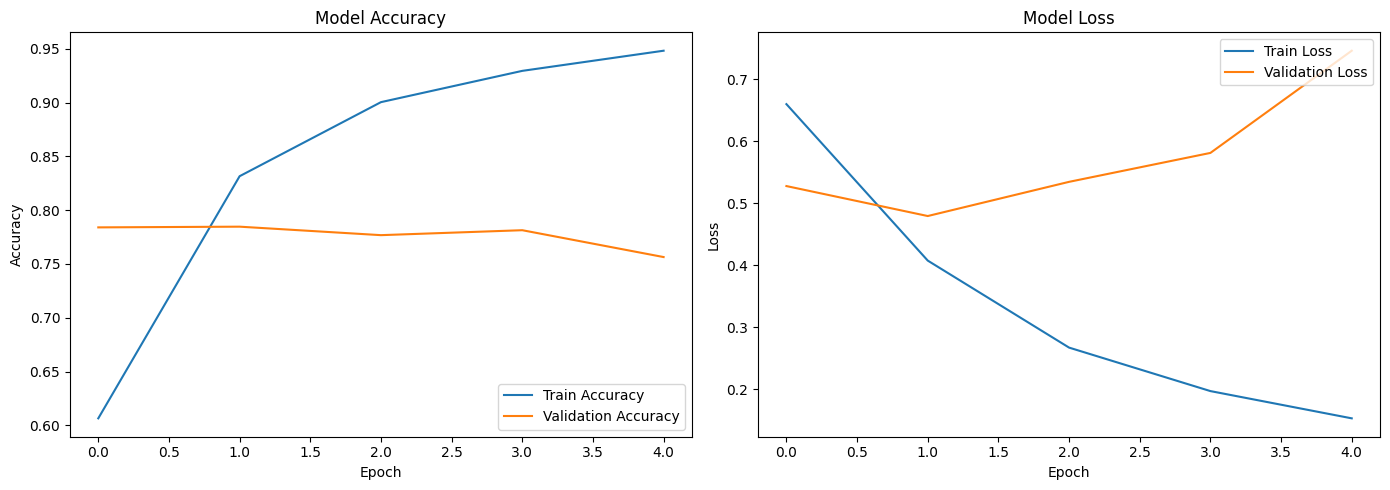

In [27]:
# Plotting Training History

# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


# Model Evaluation

After training, we evaluate the model's performance on the validation set using various metrics.


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       874
           1       0.75      0.74      0.74       649

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523



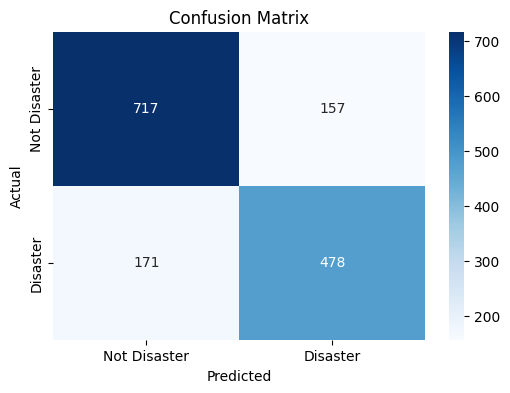

Validation Accuracy: 0.7846


In [28]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.keras')

# Predictions on validation set
y_pred = (best_model.predict(X_val) > 0.5).astype("int32").reshape(-1)

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy Score
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")


In [33]:
# Making Predictions on Test Data
# Predict on test data
test_pred = (best_model.predict(test_padded) > 0.5).astype("int32").reshape(-1)
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission['target'] = test_pred
submission.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [34]:
submission.to_csv('submission.csv', index=False)